In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### UNI transaction data querying (from Google Big Query) using Kaggle's public dataset BigQuery integration.

In [6]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import time
import zipfile
from tqdm import tqdm
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_ethereum" dataset (https://www.kaggle.com/bigquery/ethereum-blockchain)
dataset_ref = client.dataset("crypto_ethereum", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "crypto_ethereum" dataset
tables = list(client.list_tables(dataset))

Using Kaggle's public dataset BigQuery integration.


In [7]:
def query_to_csv(sql, output_path): 
    df = client.query(sql).to_dataframe(progress_bar_type='tqdm_notebook')
    df.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path), compression='gzip')

In [8]:
sql = '''
SELECT token_address, from_address, to_address,block_timestamp, cast(value AS NUMERIC) FROM 
`bigquery-public-data.crypto_ethereum.token_transfers` 
WHERE token_address = "0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"
'''
df = client.query(sql).to_dataframe(progress_bar_type='tqdm_notebook')
#df.to_csv("UNI_transaction.csv")

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Downloading:   0%|          | 0/2435974 [00:00<?, ?rows/s]

In [9]:
#UNI_tx data cleaning
df.rename(columns={'f0_':'value'}, inplace = True)
df = df.dropna()
df['value'] = df['value'].apply(lambda x: float(x))
df['timestamp'] = pd.to_datetime(df['block_timestamp'])
df['timestamp'] = df['timestamp'].apply(lambda x: str(x)[:10])
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Time period: 2020-9-18  to 2021-4-25
df = df[df['timestamp']>'2020-09-17']
df = df[df['timestamp']<'2021-04-25']
df.head()

,token_address,from_address,to_address,block_timestamp,value,timestamp
0,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x005561e55a65d8477f1c407606c90e1f6d8398a9,0xbed340a301b4f07fa7b61ab9e0767faa172f530d,2020-10-01 00:36:13+00:00,8.897805e+20,2020-10-01
1,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0xa6fb5fe53a372d5318a37c42facb85de390354cb,0xd3d2e2692501a5c9ca623199d38826e513033a17,2020-10-01 01:37:58+00:00,7.000000e+21,2020-10-01
2,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x41d93cd9dc955ea42f235338449f6d7161736241,0xd3d2e2692501a5c9ca623199d38826e513033a17,2020-10-01 01:37:58+00:00,3.629431e+19,2020-10-01
3,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x69e0af70893f565a598636baca2ae332b8dd3303,0xd3d2e2692501a5c9ca623199d38826e513033a17,2020-10-01 03:38:26+00:00,1.800000e+19,2020-10-01
4,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0x36bc3b87ba6b4636a96aef8b0058856d05cf5e68,0xf2d255ff26efb5137c0a4681b151eb7d53441069,2020-10-01 03:38:26+00:00,1.033387e+20,2020-10-01


# 1. UNI Transaction Data Preprocessing

## 1.1 Set thresholds for active addresses

In [10]:
#Active senders (Multidegree p-value:0.05)
sender_mdegree= df.groupby(['from_address'])['to_address'].count().reset_index()
print(sender_mdegree["to_address"].describe())
mu =sender_mdegree['to_address'].mean() 
sigma =sender_mdegree['to_address'].std() 
print("Threshold for Active Sender Weighted Degree:",mu+2*sigma)
actsen_mdegree = sender_mdegree[sender_mdegree['to_address']>mu+2*sigma]

#Active receiver (Multidegree p-value:0.05)
receiver_mdegree = df.groupby(['to_address'])['from_address'].count().reset_index()
print(receiver_mdegree["from_address"].describe())
mu =receiver_mdegree['from_address'].mean() 
sigma =receiver_mdegree['from_address'].std() 
print("Threshold for Active Receiver Weighted Degree:",mu+2*sigma)
actrec_mdegree = receiver_mdegree[receiver_mdegree['from_address']>mu+2*sigma]

#Active senders (Transaction value p-value 0.05)
df_sender_txval_tot = df.groupby(['from_address'])['value'].sum().reset_index()
print(df_sender_txval_tot["value"].describe())
mu =df_sender_txval_tot['value'].mean() 
sigma =df_sender_txval_tot['value'].std() 
print("Threshold for Active Sender Transaction Value:",mu+2*sigma)
actsen_val = df_sender_txval_tot[df_sender_txval_tot['value']>mu+2*sigma]

#Active receivers (Transaction value p-value 0.05)
df_receiver_txval_tot = df.groupby(['to_address'])['value'].sum().reset_index()
print(df_receiver_txval_tot["value"].describe())
mu =df_receiver_txval_tot['value'].mean() 
sigma =df_receiver_txval_tot['value'].std() 
print("Threshold for Active Receiver Transaction Value:",mu+2*sigma)
actrec_val = df_receiver_txval_tot[df_receiver_txval_tot['value']>mu+2*sigma]

count    521073.000000
mean          3.840585
std         314.354118
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      193446.000000
Name: to_address, dtype: float64
Threshold for Active Sender Weighted Degree: 632.548820880529
count    614442.000000
mean          3.256980
std         400.025898
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      300529.000000
Name: from_address, dtype: float64
Threshold for Active Receiver Weighted Degree: 803.3087760338924
count    5.210730e+05
mean     7.963759e+21
std      7.237932e+23
min      0.000000e+00
25%      2.000000e+19
50%      2.000000e+20
75%      4.000000e+20
max      3.543645e+26
Name: value, dtype: float64
Threshold for Active Sender Transaction Value: 1.4555501867473043e+24
count    6.144420e+05
mean     6.753607e+21
std      6.587059e+23
min      0.000000e+00
25%      1.000000e+19
50%      6.947737e+19
75%      4.000000e+20
max      

In [11]:
#Multigraph Active Senders and receivers (Mdegree & value)
active_sender_mul = pd.merge(actsen_mdegree,actsen_val,how='inner',on="from_address")
active_receiver_mul = pd.merge(actrec_mdegree,actrec_val,how='inner',on="to_address")

## 1.2 Lifetime distribution of active addresses

In [17]:
newdf_from = pd.merge(active_sender_mul,df,how='inner',on="from_address")
newdf_to = pd.merge(active_receiver_mul,df,how='inner',on="to_address")
newdf_from.rename(columns={'from_address':'address'}, inplace = True)
newdf_to.rename(columns={'to_address':'address'}, inplace = True)
actadr= newdf_from.append(newdf_to)

In [18]:
max_date=actadr[["address","timestamp"]].groupby(by = "address",as_index=False).max()
min_date=actadr[["address","timestamp"]].groupby(by = "address",as_index=False).min()
actadr_life=pd.merge(min_date,max_date, on="address")
actadr_life['lifetime'] = actadr_life['timestamp_y'] - actadr_life['timestamp_x']

In [19]:
max_date_sender=newdf_from[["address","timestamp"]].groupby(by = "address",as_index=False).max()
min_date_sender=newdf_from[["address","timestamp"]].groupby(by = "address",as_index=False).min()
max_date_receiver=newdf_to[["address","timestamp"]].groupby(by = "address",as_index=False).max()
min_date_receiver=newdf_to[["address","timestamp"]].groupby(by = "address",as_index=False).min()
actsen_life=pd.merge(min_date_sender,max_date_sender, on="address")
actrec_life=pd.merge(min_date_receiver,max_date_receiver, on="address")
actsen_life['lifetime'] = actsen_life['timestamp_y'] - actsen_life['timestamp_x']
actrec_life['lifetime'] = actrec_life['timestamp_y'] - actrec_life['timestamp_x']

actadr_life["days"]=actadr_life['lifetime'].dt.days
actsen_life["days"]=actsen_life['lifetime'].dt.days
actrec_life["days"]=actrec_life['lifetime'].dt.days

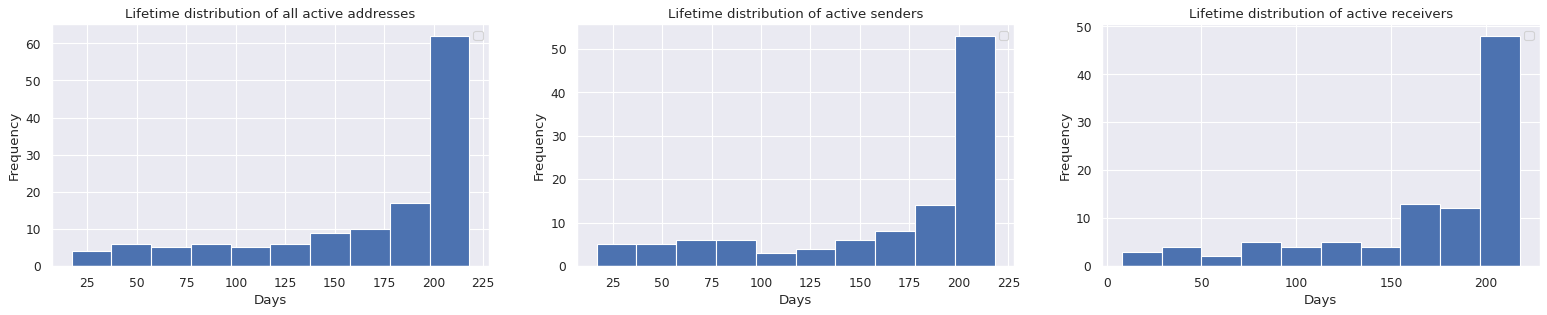

In [20]:
import seaborn as sns
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns 

sns.set_context("talk")
sns.set(rc={'figure.figsize':(9,6)}) 
fig = plt.figure(num=3, figsize=(24, 4),dpi=80)
ax1=fig.add_subplot(1,3,1)
plt.title ("Lifetime distribution of all active addresses")
plt.xlabel('Days')
plt.ylabel('Frequency')
ax2=fig.add_subplot(1,3,2)
plt.title ("Lifetime distribution of active senders")
plt.xlabel('Days')
plt.ylabel('Frequency')
ax3=fig.add_subplot(1,3,3)
plt.title ("Lifetime distribution of active receivers")
plt.xlabel('Days')
plt.ylabel('Frequency')
ax1.hist(actadr_life["days"])
ax2.hist(actsen_life["days"])
ax3.hist(actrec_life["days"])
ax1.legend()
ax2.legend()
ax3.legend()

## 1.3 Calculate and plot the transaction value of active addresses and non-active address

In [21]:
#Get the data for active sender and active receiver
#A
actsen = df[df['from_address'].isin(active_sender_mul['from_address'])]
actsenrec = actsen[actsen['to_address'].isin(active_receiver_mul['to_address'])]
#B
actsen_nonarec = actsen[~actsen['to_address'].isin(active_receiver_mul['to_address'])]
actsen_nonarec
#C
actrec = df[df['to_address'].isin(active_receiver_mul['to_address'])]
actrec_nonasen = actrec[~actrec['from_address'].isin(active_sender_mul['from_address'])]
#D
nonasen = df[~df['from_address'].isin(active_sender_mul['from_address'])]
nonasenrec = nonasen[~nonasen['to_address'].isin(active_receiver_mul['to_address'])]

In [25]:
#总交易额
txval = df.groupby(['timestamp'])['value'].sum().reset_index()
txval.rename(columns={'value':'total_value'}, inplace = True)
#大户与大户总交易额
txval_actsenrec = actsenrec.groupby(['timestamp'])['value'].sum().reset_index()
txval['txval_actsenrec'] = txval_actsenrec['value']
#大户与散户总交易额
txval_actsen_nonarec = actsen_nonarec.groupby(['timestamp'])['value'].sum().reset_index()
txval_actrec_nonasen = actrec_nonasen.groupby(['timestamp'])['value'].sum().reset_index()
txval['txval_act_nonact'] = txval_actsen_nonarec['value']+txval_actrec_nonasen['value']
#大户与所有户总交易额
txval_actsen = actsen.groupby(['timestamp'])['value'].sum().reset_index()
txval_actrec = actrec.groupby(['timestamp'])['value'].sum().reset_index()
txval['txval_act_tot'] = txval_actsen['value']+txval_actrec['value'] - txval['txval_actsenrec']
#散户与散户总交易额
txval_nonasenrec = nonasenrec.groupby(['timestamp'])['value'].sum().reset_index()
txval['txval_nonact'] = txval_nonasenrec['value']
txval['total'] = txval['txval_actsenrec']+txval['txval_act_nonact']+txval['txval_nonact']
#txval= txval.drop(['total'], axis=1)
#Calculate the ratio
txval['ratio_actsenrec/tot'] = txval['txval_actsenrec']/txval['total_value']
txval['ratio_act_nonact/tot'] = txval['txval_act_nonact']/txval['total_value']
txval['ratio_nonact/tot'] = txval['txval_nonact']/txval['total_value']
txval['ratio_act_tot/tot'] = txval['txval_act_tot']/txval['total_value']
txval['ratio_actsenrec/act_tot'] = txval['txval_actsenrec']/txval['txval_act_tot']

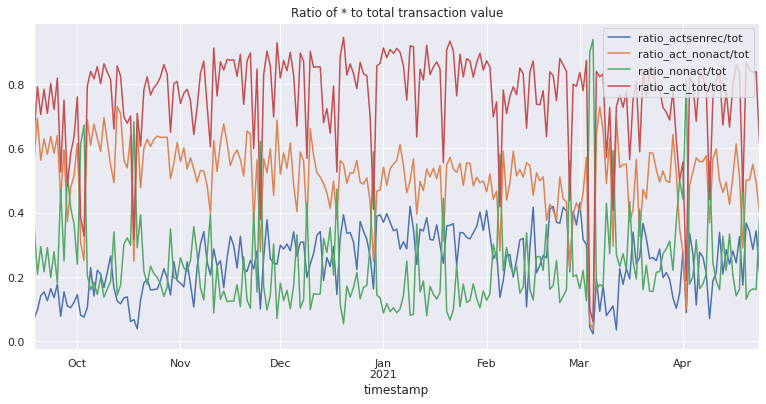

In [23]:
#Plot the ratio of * to total transaction value
txval.plot(x = 'timestamp', y = ['ratio_actsenrec/tot','ratio_act_nonact/tot','ratio_nonact/tot','ratio_act_tot/tot'],subplots=False, figsize=(13,6), grid=True, title='Ratio of * to total transaction value')
plt.show()

# 2. Network Analysis

## 2.1 Network building & Number of daily edges and nodes

In [26]:
df_time_partition= df.groupby(['timestamp'])['to_address'].agg(['nunique']).reset_index()
df_time_partition = df_time_partition.drop(['nunique'], axis=1)
df_time_partition['No.of nodes']=0
df_time_partition["No.of edges"]=0

In [28]:
# Daily Network Building
import networkx as nx
num_nodes = []
num_edges = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.MultiGraph())
    
    # Calculation of Number of nodes, number of edges
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    num_nodes.append(nodes)
    num_edges.append(edges)

In [30]:
nodes_edges={"num_nodes" : num_nodes,"num_edges" : num_edges}
nodes_edges=pd.DataFrame(nodes_edges)
nodes_edges['time'] =  df_time_partition['timestamp']

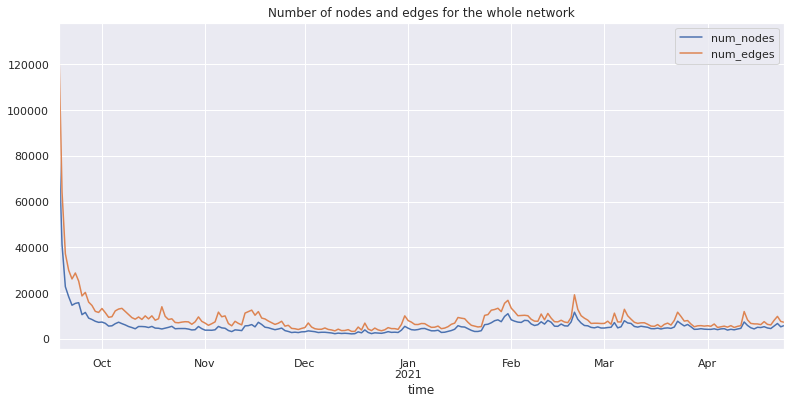

In [31]:
# Number of edges and nodes plot
nodes_edges.plot(x ='time', y =['num_nodes',"num_edges"],subplots=False, figsize=(13,6), grid=True, title='Number of nodes and edges for the whole network')
plt.show()

## 2.2 Network Visualization

In [32]:
# Data Partition
df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][20]]
df_1['value'] = df_1['value'].apply(lambda x: float(x))
df_1["value"]=df_1["value"]/30000000000000000000000
G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', ['value'],  create_using=nx.MultiDiGraph())
pos = nx.layout.spring_layout(G)  # positions for all nodes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


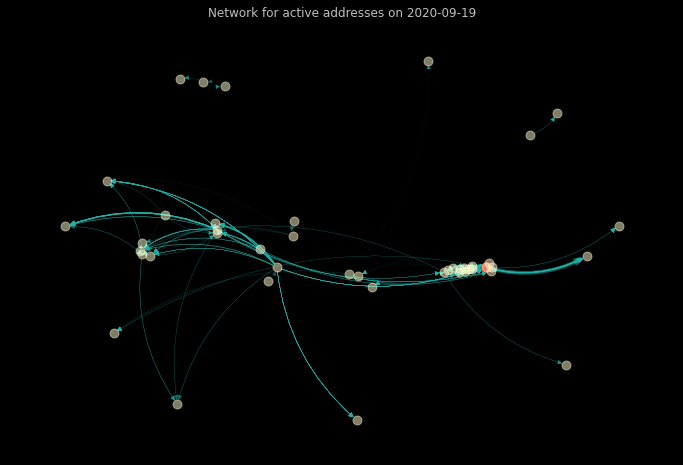

In [33]:
# Visualize the network for a specific date
date=1
df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][date]]
df_1['value'] = df_1['value'].apply(lambda x: float(x))
df_1["value"]=df_1["value"]/30000000000000000000000
#Build the network
G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', ['value'],  create_using=nx.MultiDiGraph())
pos = nx.layout.spring_layout(G)  # positions for all nodes
fig = plt.figure(figsize=(12,8))
plt.rcParams['figure.dpi'] = 500
plt.title('Network for active addresses on 2020-09-19',color="silver")
#emphasize the critical point
nx.draw_networkx_nodes(G, pos=pos, nodelist=["0xd3d2e2692501a5c9ca623199d38826e513033a17"], node_size=90,alpha=0.9, node_color="#FF0000")
nx.draw(G,pos,edge_color='lightseagreen',node_color='lemonchiffon',connectionstyle='arc3, rad = 0.2',node_size=80,alpha=0.5,width=[float(v['value']) for (r,c,v) in G.edges(data=True)])
fig.set_facecolor((0,0,0))
plt.savefig("Graph.png", format="PNG")
plt.show()

In [ ]:
# a for loop Visualizing the network for 100+ Dates, and save as "d.jpg"
for i in range (135,len(df_time_partition)):
    # Data Partition
    df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    df_1['value'] = df_1['value'].apply(lambda x: float(x))
    df_1["value"]=df_1["value"]/30000000000000000000000
    
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', ['value'],  create_using=nx.MultiDiGraph())
    pos = nx.layout.spring_layout(G)  # positions for all nodes
    fig = plt.figure(figsize=(12,8))
    plt.rcParams['figure.dpi'] = 500
    plt.title('Network for active addresses on {}'.format(df_time_partition['timestamp'][i]),color="silver")
    nx.draw_networkx_nodes(G, pos=pos, nodelist=["0xd3d2e2692501a5c9ca623199d38826e513033a17"], node_size=95,alpha=1, node_color="#FF0000")
    nx.draw(G,pos,edge_color='lightseagreen',node_color='lemonchiffon',connectionstyle='arc3, rad = 0.2',node_size=80,alpha=0.5,width=[float(v['value']) for (r,c,v) in G.edges(data=True)])
    fig.set_facecolor((0,0,0))
    plt.savefig("%d.jpg"%(i+1))

## 2.3 Calculate Network Features for All Transaction Data (all addresses)

### 2.3.1 Degree Centrality

In [34]:
import networkx as nx
DCmean = []
DCstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.MultiDiGraph())
    
    # Calculation of Degree_centrality, mean_value
    deg_cen = nx.degree_centrality(G)
    df_deg = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Degree_Centrality'])
    DC_mean = df_deg['Degree_Centrality'].mean()
    DC_std = df_deg['Degree_Centrality'].std()
    DCmean.append(DC_mean)
    DCstd.append(DC_std)

### 2.3.2 Clustering Coefficient

In [35]:
clustermean = []
clusterstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # Unweighted-Directed Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.DiGraph())
    
    # Calculation of Clustering_Coefficient, mean_value, std
    clustering = nx.clustering(G)
    df_cluster = pd.DataFrame.from_dict(clustering, orient='index', columns=['Clustering_Coefficient'])
    cluster_mean = df_cluster['Clustering_Coefficient'].mean()
    cluster_std = df_cluster['Clustering_Coefficient'].std()
    clustermean.append(cluster_mean)
    clusterstd.append(cluster_std)

### 2.3.3 Modularity

In [36]:
import community
mod_list = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of modularity
    part = community.best_partition(G)
    mod = community.modularity(part,G)
    mod_list.append(mod)

### 2.3.4 Transitivity

In [37]:
tran_list = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # Unweighted-undirected Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.Graph())
    
    # Calculation of transitivity, 
    tran = nx.transitivity(G)
    tran_list.append(tran)

### 2.3.5 Eigenvector Centrality

In [38]:
eigmean = []
eigstd = []
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    #df_1 = actsenrec.loc[actsenrec['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.DiGraph())
    
    # Calculation of Closeness_centrality, mean_value
    eig_cen = nx.eigenvector_centrality(G, max_iter=500)
    df_eig = pd.DataFrame.from_dict(eig_cen, orient='index', columns=['eigenvector_centrality'])
    eig_mean = df_eig['eigenvector_centrality'].mean()
    eig_std = df_eig['eigenvector_centrality'].std()
    eigmean.append(eig_mean)
    eigstd.append(eig_std)

In [40]:
Network_Features={"DCmean" : DCmean,"DCstd" : DCstd, "clustermean": clustermean, "clusterstd": clusterstd,
                  "modularity": mod_list, "transitivity": tran_list, "eig_mean" : eigmean,"eig_std" : eigstd}
Network_features=pd.DataFrame(Network_Features)
Network_features['time'] =  df_time_partition['timestamp']

### 2.3.6 Critical Point

In [ ]:
import networkx as nx
frames=pd.DataFrame()
#new['Degree_Centrality']=0
for i in range(0,len(df_time_partition)):
    
    # Data Partition
    df_1 = df.loc[df['timestamp']==df_time_partition['timestamp'][i]]
    
    # MultiDi Network Building (weighted-directed graph)
    G = nx.from_pandas_edgelist(df_1, 'from_address', 'to_address', 'value', nx.MultiDiGraph())
    
    # get the maximum degree and its correspon
    deg_cen = nx.degree_centrality(G)
    df_deg = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Degree_Centrality'])
    DC_max = df_deg['Degree_Centrality'].max()
    argmax = df_deg[df_deg['Degree_Centrality'] == DC_max]
    frames=pd.concat([frames,argmax])

In [ ]:
frames.index.name = 'node'

In [ ]:
from_critical=df.loc[df['from_address']=="0xd3d2e2692501a5c9ca623199d38826e513033a17"]
to_critical=df.loc[df['to_address']=="0xd3d2e2692501a5c9ca623199d38826e513033a17"]
critical=pd.concat([from_critical,to_critical])
critical_value = critical.groupby(['timestamp'])['value'].sum().reset_index()
critical_degree = critical.groupby(['timestamp'])['value'].count().reset_index()
critical_degree= critical_degree.rename(columns={"value":"degree","timestamp":"date"})
cp=pd.concat([critical_value,critical_degree],axis=1)
cp.drop('date',axis=1, inplace=True)
cp.to_csv("critical_point.csv")

# 3. Input variable statistical analysis and plotting

In [42]:
# Read UNI_info data
UNI_info_data= pd.read_csv('../input/uniinfo/uni.csv')
UNI_info_data = UNI_info_data[UNI_info_data['time']>'2020-09-17']
UNI_info_data = UNI_info_data.reset_index()

In [43]:
Network_features['priceUSD'] = UNI_info_data['PriceUSD']
Network_features['SplyFF'] = UNI_info_data['SplyFF']
Network_features['TxTfrValMeanUSD'] = UNI_info_data['TxTfrValMeanUSD']
Network_features['TxTfrValUSD'] = UNI_info_data['TxTfrValUSD']

In [44]:
# Outliers
mu =Network_features['TxTfrValUSD'].mean() 
sigma =Network_features['TxTfrValUSD'].std() 
outlier = Network_features[Network_features['TxTfrValUSD']>mu+3*sigma]
mu1 =Network_features['TxTfrValMeanUSD'].mean() 
sigma1 =Network_features['TxTfrValMeanUSD'].std() 
outlier1 = Network_features[Network_features['TxTfrValMeanUSD']>mu1+3*sigma1]

#Dealling with outliers
df_scale = Network_features.copy()
df_scale['TxTfrValMeanUSD'][df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]] = df_scale['TxTfrValMeanUSD'][df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]-10:df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]].mean()
df_scale['TxTfrValMeanUSD'][df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]] = df_scale['TxTfrValMeanUSD'][df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]-10:df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]].mean()
df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]] = df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]-10:df_scale[(df_scale['time']=='2021-03-04')].index.tolist()[0]].mean()
df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]] = df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]-10:df_scale[(df_scale['time']=='2021-03-05')].index.tolist()[0]].mean()
df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-07')].index.tolist()[0]] = df_scale['TxTfrValUSD'][df_scale[(df_scale['time']=='2021-03-07')].index.tolist()[0]-10:df_scale[(df_scale['time']=='2021-03-07')].index.tolist()[0]].mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/l

In [45]:
UNI_df = df_scale
UNI_df.to_csv("UNI_df.csv")

In [46]:
#Critical Point data processing
cp = pd.read_csv("../input/criticalpoint/critical_point.csv")
cp = cp.drop(['Unnamed: 0'], axis=1)
cp.rename(columns={'timestamp':'time'}, inplace = True)
cp.rename(columns={'value':'cp_value'}, inplace = True)
cp.rename(columns={'degree':'cp_degree'}, inplace = True)

In [47]:
UNI_df= pd.read_csv('UNI_df.csv')
UNI_df = UNI_df.drop(['Unnamed: 0'], axis=1)
#merge critical point data to other input variables
df_ = pd.merge(UNI_df,cp,how='inner',on="time")
df1 = df_.drop('time', axis=1)

In [48]:
#Normalize all values to [0,10]
import pandas as pdimport 
from sklearn.preprocessing import MinMaxScaler  
transfer = MinMaxScaler(feature_range=(0,10)) 
data = df1.values
data = transfer.fit_transform(data)
data = pd.DataFrame(data)

data.rename(columns={0:'DCmean'}, inplace = True)
data.rename(columns={1:'DCstd'}, inplace = True)
data.rename(columns={2:'clustermean'}, inplace = True)
data.rename(columns={3:'clusterstd'}, inplace = True)
data.rename(columns={4:'modularity'}, inplace = True)
data.rename(columns={5:'transitivity'}, inplace = True)
data.rename(columns={6:'eig_mean'}, inplace = True)
data.rename(columns={7:'eig_std'}, inplace = True)
data.rename(columns={8:'priceUSD'}, inplace = True)
data.rename(columns={9:'SplyFF'}, inplace = True)
data.rename(columns={10:'TxTfrValMeanUSD'}, inplace = True)
data.rename(columns={11:'TxTfrValUSD'}, inplace = True)
data.rename(columns={12:'cp_value'}, inplace = True)
data.rename(columns={13:'cp_degree'}, inplace = True)

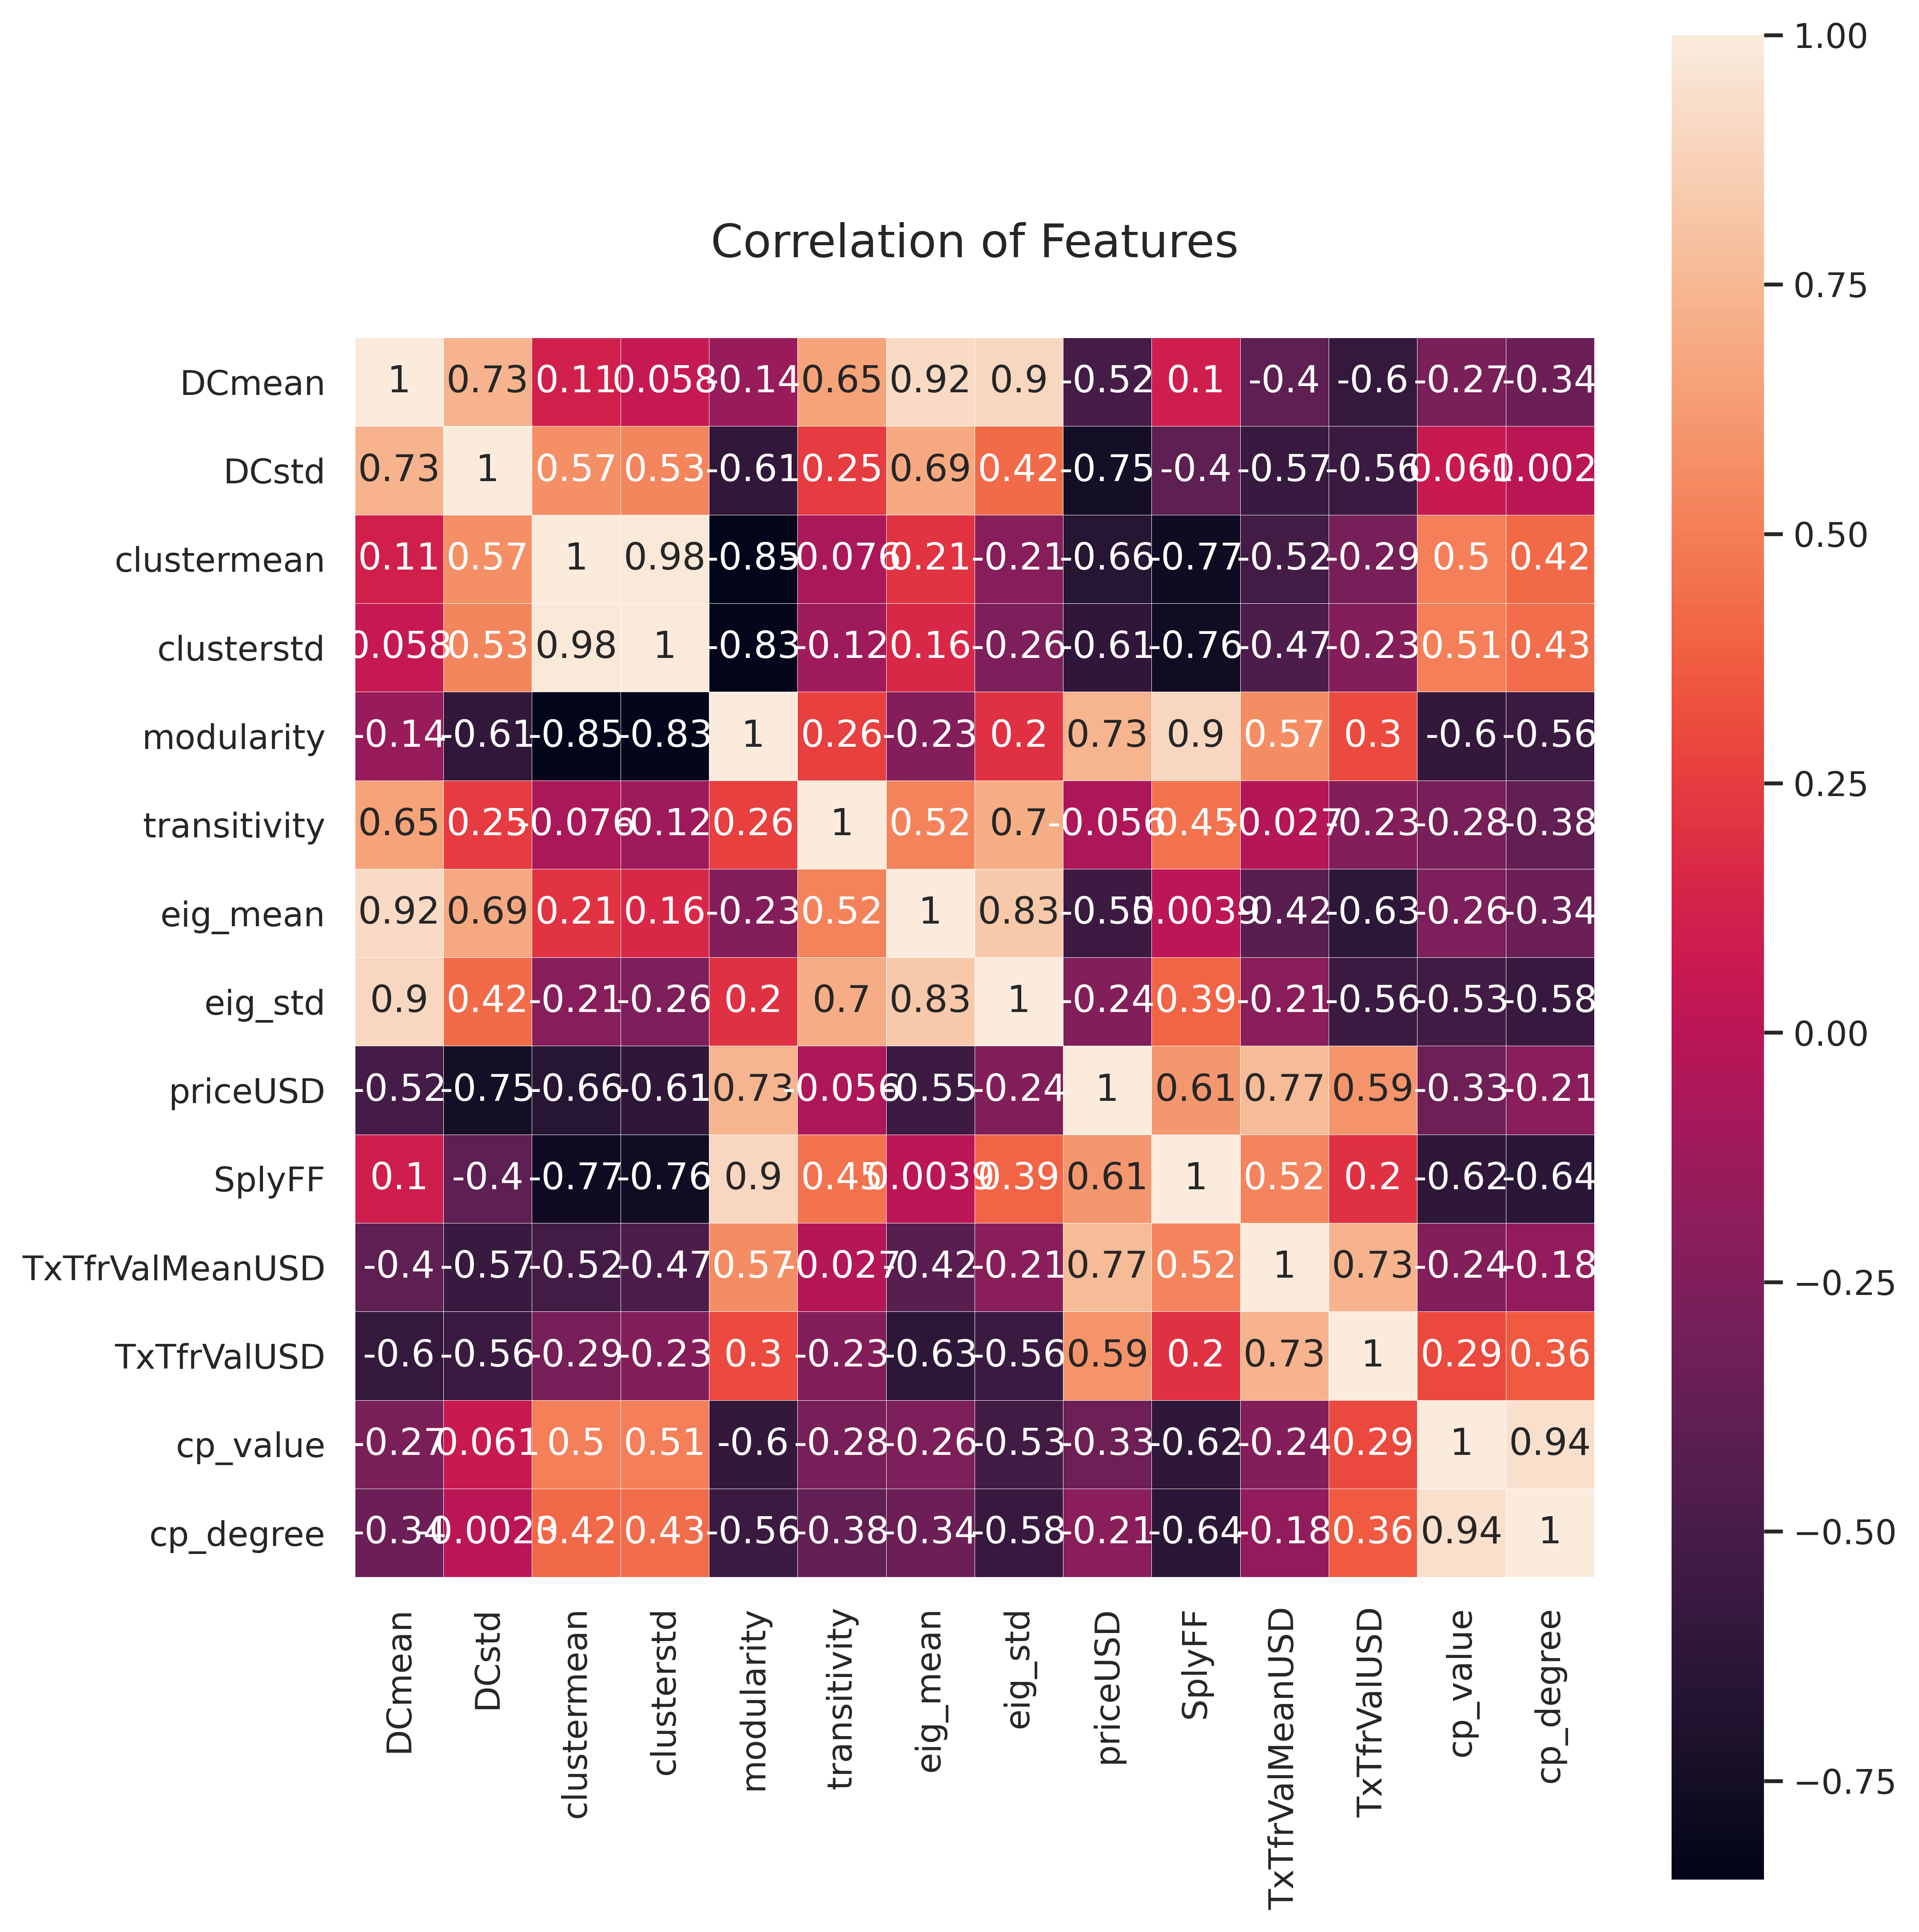

In [56]:
#Draw the correlation heatmap of the main features
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,11))
plt.title('Correlation of Features',y=1.05,size=15)
sns.heatmap(df1.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.xticks(rotation=90)  
plt.yticks(rotation=360)
plt.show()

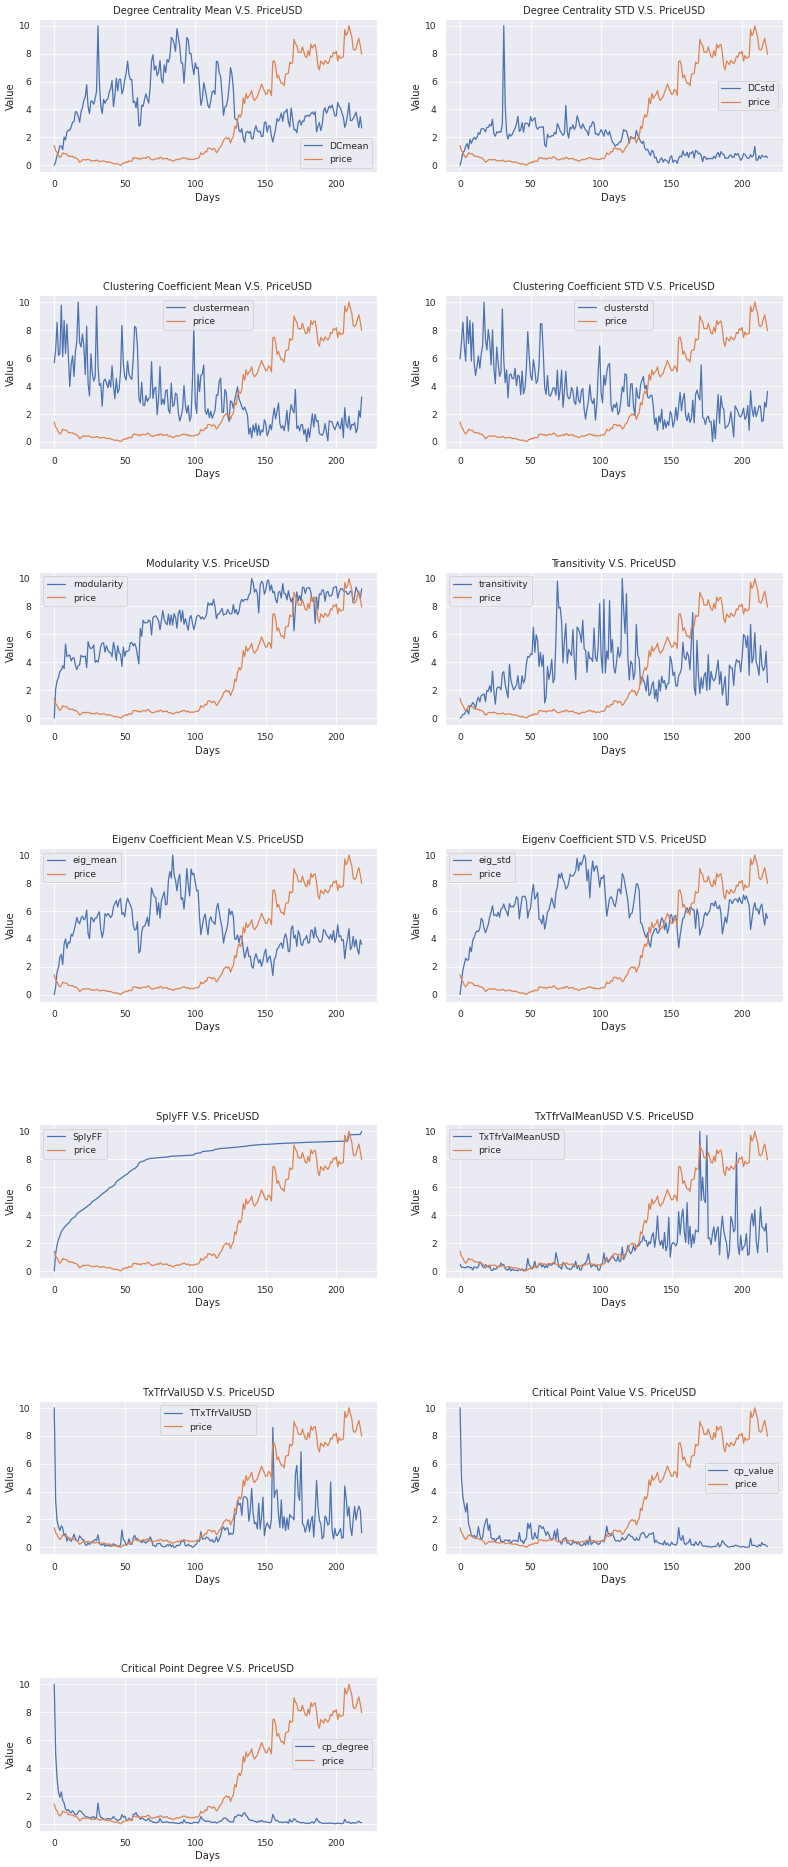

In [52]:
#Draw plots of all input variables vs. priceUSD
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
df = data

sns.set_context("talk")
sns.set(rc={'figure.figsize':(16,20)}) 

fig = plt.figure(num=13, figsize=(16, 40),dpi=60)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)
ax1=fig.add_subplot(7,2,1)
plt.title ("Degree Centrality Mean V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax2=fig.add_subplot(7,2,2)
plt.title ("Degree Centrality STD V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax3=fig.add_subplot(7,2,3)
plt.title ("Clustering Coefficient Mean V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax4=fig.add_subplot(7,2,4)
plt.title ("Clustering Coefficient STD V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax5=fig.add_subplot(7,2,5)
plt.title ("Modularity V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax6=fig.add_subplot(7,2,6)
plt.title ("Transitivity V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax7=fig.add_subplot(7,2,7)
plt.title ("Eigenv Coefficient Mean V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax8=fig.add_subplot(7,2,8)
plt.title ("Eigenv Coefficient STD V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax9=fig.add_subplot(7,2,9)
plt.title ("SplyFF V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax10=fig.add_subplot(7,2,10)
plt.title ("TxTfrValMeanUSD V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax11=fig.add_subplot(7,2,11)
plt.title ("TxTfrValUSD V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax12=fig.add_subplot(7,2,12)
plt.title ("Critical Point Value V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')
ax13=fig.add_subplot(7,2,13)
plt.title ("Critical Point Degree V.S. PriceUSD")
plt.xlabel('Days')
plt.ylabel('Value')

ax1.plot(df['DCmean'], label='DCmean')
ax1.plot(df['priceUSD'], label='price')
ax2.plot(df['DCstd'], label='DCstd')
ax2.plot(df['priceUSD'], label='price')
ax3.plot(df['clustermean'], label='clustermean')
ax3.plot(df['priceUSD'], label='price')
ax4.plot(df['clusterstd'], label='clusterstd')
ax4.plot(df['priceUSD'], label='price')
ax5.plot(df['modularity'], label='modularity')
ax5.plot(df['priceUSD'], label='price')
ax6.plot(df['transitivity'], label='transitivity')
ax6.plot(df['priceUSD'], label='price')
ax7.plot(df['eig_mean'], label='eig_mean')
ax7.plot(df['priceUSD'], label='price')
ax8.plot(df['eig_std'], label='eig_std')
ax8.plot(df['priceUSD'], label='price')
ax9.plot(df['SplyFF'], label='SplyFF')
ax9.plot(df['priceUSD'], label='price')
ax10.plot(df['TxTfrValMeanUSD'], label='TxTfrValMeanUSD')
ax10.plot(df['priceUSD'], label='price')
ax11.plot(df['TxTfrValUSD'], label='TTxTfrValUSD')
ax11.plot(df['priceUSD'], label='price')
ax12.plot(df['cp_value'], label='cp_value')
ax12.plot(df['priceUSD'], label='price')
ax13.plot(df['cp_degree'], label='cp_degree')
ax13.plot(df['priceUSD'], label='price')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()
ax9.legend()
ax10.legend()
ax11.legend()
ax12.legend()
ax13.legend()